In [1]:
!nvidia-smi

Thu May  2 05:49:02 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 551.78                 Driver Version: 551.78         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   36C    P0             22W /   80W |       0MiB /   6144MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Roberta Base Model

In [2]:
import os
import pandas as pd
import numpy as np

import torch
from torch.utils.data import Dataset, DataLoader, random_split

from transformers import AutoTokenizer, AutoModel

In [3]:
# setting the model name
PRE_TRAINED_MODEL_NAME = 'roberta-base'

# setting the dataset
dataset='MBTI 500 multi_label.csv'


# setting the data path
if os.path.exists(f'/datasets/mbti/{dataset}'):
    DATAPATH=f'/datasets/mbti/{dataset}'
else:
    DATAPATH=f'../data/{dataset}'

# setting the checkpoint path 
if os.path.exists('ckpts'):
    CHECKPOINTPATH = 'ckpts/Persnality_MBTI'
else:
    CHECKPOINTPATH = '../ckpts/Persnality_MBTI'

# training parameters
MAX_LEN = 512
TRAIN_BATCH_SIZE = 20
VALID_BATCH_SIZE = 16
TEST_BATCH_SIZE = 16
EPOCHS = 10
THRESHOLD = 0.5 # threshold for the sigmoid function

# TOKENIZER
tokenizer = AutoTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

# setting the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# setting the random seed
torch.manual_seed(99)
torch.cuda.manual_seed(99)
torch.cuda.manual_seed_all(99)
np.random.seed(99)

In [4]:
DATAPATH,CHECKPOINTPATH

('../data/MBTI 500 multi_label.csv', '../ckpts/Persnality_MBTI')

### Loading the Data

In [5]:
# load the data
data = pd.read_csv(DATAPATH,encoding='utf-8')

In [6]:
# get the labels list
labels_list = data.columns[2:].tolist()
print(f'Labels list: {labels_list}')

Labels list: ['IE', 'NS', 'TF', 'JP']


#### Load the model

In [7]:
# import model
import sys
sys.path.append('../Models')
import MBTI_model_shap as model


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [8]:
model_no_words = model.ROBERTAClass(PRE_TRAINED_MODEL_NAME)
model_no_words.load_state_dict(torch.load(CHECKPOINTPATH + f'_clean_Best_{PRE_TRAINED_MODEL_NAME}.bin', map_location=torch.device(device)))
model_no_words.to(device)
print(f'{PRE_TRAINED_MODEL_NAME}_no_words loaded')
model_no_words.eval()

torch.set_grad_enabled(False)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


roberta-base_no_words loaded


### SHAP

In [9]:
import shap
shap.initjs()

### Calculate the SHAP values

In [10]:
text= "I am a very shy person and I prefer to be alone."

In [11]:
# shap values "call the model.explain method with the model, text data to explain and aspect"
shap_values_IE= model.explain_model(model_no_words,[text],aspect='IE')

In [12]:
text2="I think people are generally good and I trust them. I am very empathetic and I like to help others. I am very compassionate and I like to make others feel good."

In [13]:
shap_values_TF= model.explain_model(model_no_words,[text2],aspect='TF')

In [14]:
model_no_words.getProbabilities(np.array([text]))

tensor([[0.0655, 0.2378, 0.3937, 0.2727]], device='cuda:0')

### Plot the shap values

In [15]:
shap.plots.text(shap_values_IE)

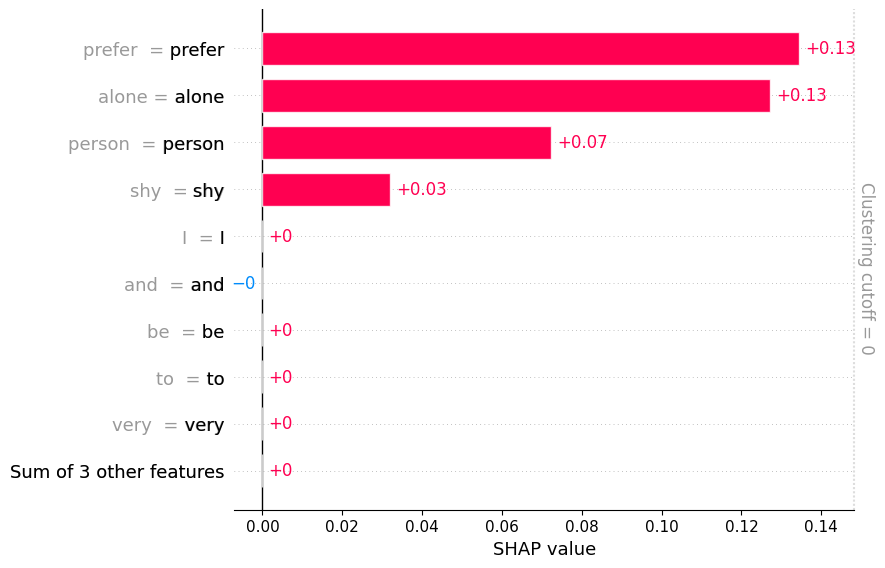

In [16]:
shap.plots.bar(shap_values_IE[0,:,0], clustering_cutoff=0)

In [17]:
shap.plots.text(shap_values_TF)

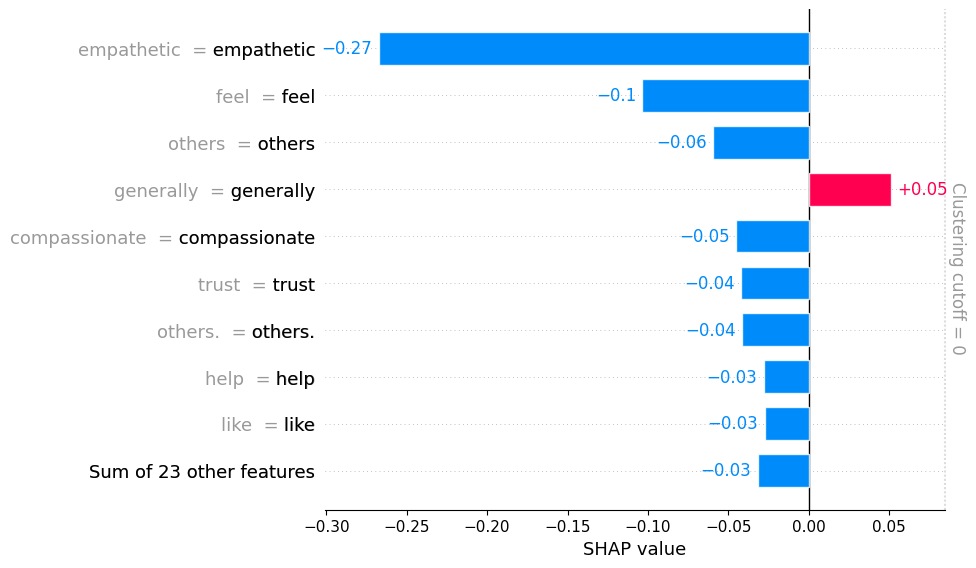

In [18]:
shap.plots.bar(shap_values_TF[0,:,0], clustering_cutoff=0)

In [19]:
# text3 to test NS
text3="I am a very logical person and I like to think about things before I act. I am very analytical and I like to solve problems."

shap_values_NS= model.explain_model(model_no_words,[text3],aspect='NS')

In [20]:
# plot the text explanation
shap.plots.text(shap_values_NS)

In [23]:
# text to test JP on judging
text4="I judge people based on their actions and I like to plan things ahead of time. I am very organized and I like to have a plan for everything."
shap_values_JP= model.explain_model(model_no_words,[text4],aspect='JP')


In [24]:
shap.plots.text(shap_values_JP)